In [1]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from train_model import generate_paper_experiments

In [2]:
experiments = generate_paper_experiments()

In [3]:
global_save_path = os.path.join("..", "datasets", "paper_experiments_catboost")
predictions_save_path = os.path.join(global_save_path, "results")
plots_path = os.path.join(global_save_path, "plots")

os.makedirs(predictions_save_path, exist_ok="True")
os.makedirs(plots_path, exist_ok=True)

In [4]:
# Assumes all experiments are on the same data and use the fold defenitions!
data = pd.read_csv(os.path.join("..", experiments[0].data_path), index_col="_id")
data = data[[experiments[0].target]]
folds = pd.read_csv(os.path.join("..", experiments[0].folds_path), squeeze=True, index_col="_id")
features = pd.read_csv(os.path.join("..", experiments[0].features_path), index_col='_id')

In [5]:
def process_experiment(experiment):
    model = CatBoostRegressor()
    model.load_model(os.path.join("..", experiment.model_path))
    return model.predict(features)

In [6]:
from multiprocessing import Pool
with Pool(20) as p:
    predictions = p.map(process_experiment, experiments)

In [7]:
def get_test_prediction_column(target):
    return f"test_predicted_{target}"

In [8]:
maes = defaultdict(list)
columns_to_save = set()
for experiment, this_predictions in zip(experiments, predictions):
    test_prediction_column = get_test_prediction_column(experiment.target)
    columns_to_save.add(test_prediction_column)
    predictions_pd = pd.Series(data=this_predictions.ravel(), index=data.index)
    train_prediction_column = f"train_fold_-{experiment.test_fold}_predicted_{experiment.target}"
    columns_to_save.add(train_prediction_column)
  
    test_ids = folds[folds == experiment.test_fold].index
    train_ids = folds[folds != experiment.test_fold].index
  
    data.loc[test_ids, test_prediction_column] = predictions_pd.loc[test_ids]
    data.loc[train_ids, train_prediction_column] = predictions_pd.loc[train_ids]
    maes[experiment.target].append(np.mean(np.abs(
    predictions_pd.loc[test_ids] - data.loc[test_ids, experiment.target])))

In [9]:
targets = set(map(lambda e: e.target, experiments))

In [10]:
def plot_target(target, data_name):
    fig, ax = plt.subplots()
    mae = np.mean(maes[target])
    mae_std = np.std(maes[target])
    test_prediction_column = get_test_prediction_column(target)
    ax.scatter(data.loc[:, target], data.loc[:, test_prediction_column],
             label=f"{data_name}, $MAE={mae:.4f} \pm {mae_std:.4f}$",
             alpha=0.5)
  
    ax.set_xlabel(f"DFT {target}, eV")
    ax.set_ylabel(f"Predicted {target}, eV")
    ax.legend()

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
      ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    fig.savefig(os.path.join(plots_path, f"{target}_{data_name}.pdf"),
                bbox_inches="tight",
                metadata={
                    "Author": "Maxim Faleev",
                    "Title": f"CatBoost on matminer features, {target}, {data_name}"
                }
                )

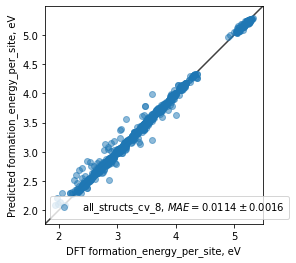

In [11]:
for target in targets:
    plot_target(target, "all_structs_cv_8")

In [12]:
data.to_csv(os.path.join(predictions_save_path, "full.csv.gz"),
            columns=columns_to_save, index_label="_id")